# All LSTM classification runs for Operator 1

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore

In [7]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 16})

## Processing functions

In [8]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

## LSTM functions

In [50]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': 
            curr_campaign = f['campaign'].iloc[i]

        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1:
            continue
    
        elif curr_campaign != f['campaign'].iloc[i]: 
            curr_campaign = f['campaign'].iloc[i]
        
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('Mode')
    
    X, y = series_split_sequences(train[features], train[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
    X_test, y_test = series_split_sequences(test[features], test[target_feature], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

    features.remove('campaign')

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), shuffle=True, verbose=0)
    
    y_pred = model.predict(X_test, verbose=0)
    y_pred = (y_pred >= 0.5).astype(int)

    train_pred = model.predict(X, verbose=0)
    train_pred = (train_pred >= 0.5).astype(int)

    if n_steps_out > 1:
        y_pred_plot, y_true_plot, train_pred_plot, train_true_plot = y_pred, y_test, train_pred, y_train
    else:
        # test data
        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(y_pred) + n_steps_in, :] = y_pred

        # train data
        train_true_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train_pred) + n_steps_in, :] = train_pred
    
    accuracy, recall, precision = metrics(y_pred=y_pred, y_true=y_test)
    train_accuracy, train_recall, train_precision = metrics(y_pred=train_pred, y_true=y)

    acc = []
    train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(y_test[:, i], y_pred[:, i]))
        train_acc.append(accuracy_score(y[:, i], train_pred[:, i]))
    
    results = {'y_pred': y_pred,
               'y_true': y_test,
               'train_true': y,
               'train_pred': train_pred,
               'y_pred_plot': y_pred_plot,
               'y_true_plot': y_true_plot,
               'train_pred_plot': train_pred_plot,
               'train_true_plot': train_true_plot,
               'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_list': acc,
               'Accuracy_train_list': train_acc
               }

    return results

def plot_mode(pred, true, operator:str, comb:str, n_steps_in:int, n_steps_out:int, test_train='Test'):
    fig = plt.figure(figsize=(10, 6))
    pred = plt.plot(np.array(pred), color=mode_colors[1], label='Predicted', zorder=2)
    true = plt.plot(np.array(true) + 2, color=mode_colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.6))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nTraining features: {comb}\nLook-back: {n_steps_in}, Looh-ahead: {n_steps_out}')
    plt.legend(handles=[pred[0], true[0]], ncols=2, loc='best')
    plt.tight_layout()
    plt.show()
    return fig

'''
    Plots the accuracy in a histogram for test and training data
'''
def plot_accuracy_timesteps(true, pred, train_true, train_pred, comb:list, n_steps_out:int, operator:str):
    acc = []
    # train_acc = []

    for i in range(n_steps_out):
        acc.append(accuracy_score(true[:, i], pred[:, i]))
        # train_acc.append(accuracy_score(train_true[:, i], train_pred[:, i]))

    # print(acc)
    # print(train_acc)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']
    x = np.arange(n_steps_out)

    width = 0.35

    fig, ax = plt.subplots(figsize=(16, 6))

    bars1 = ax.bar(x - width/2, acc, width, label='Accuracy', color=mode_colors[2], edgecolor='white')

    # bars2 = ax.bar(x + width/2, train_acc, width, label='Training Accuracy', color=mode_colors[3], edgecolor='white')

    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Step ahead')
    ax.set_title(f'{operator}\nAccuracy for each timestep ahead\nCombination of training features: {comb}')
    ax.set_xticks(x)
    ax.set_ylim(0, 1)
    ax.set_xticklabels(labels[0:n_steps_out])
    ax.legend(loc='lower right')

    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_value_labels(bars1)
    # add_value_labels(bars2)

    plt.show()
    return fig


def box_lookback(results:dict, n_steps_out:int, operator:str):
    sep1 = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'] 
    comb1 = ['RSRP, SSS_RSRP', 'SINR, SSS_SINR', 'RSRQ, SSS_RSRQ']
    cat2 = ['RSRP, SINR', 'RSRP, RSRQ', 'SINR, RSRQ', 'SSS_RSRP, SSS_SINR', 'SSS_RSRP, SSS_RSRQ', 'SSS_SINR, SSS_RSRQ']
    sep3 = ['RSRP, SINR, RSRQ', 'SSS_RSRP, SSS_SINR, SSS_RSRQ']
    comb3 = ['All']

    names = ['Cat 1', 'Cat 2', 'Cat 3', 'Cat 4', 'All']

    xncombs = list(results.keys())
    
    accs = [[[] for _ in range(len(names))] for _ in range(len(xncombs))]

    for i in range(len(xncombs)):
        for key in results[xncombs[i]]:
            if key in sep1:
                for j in range(n_steps_out):
                    accs[i][0].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb1:
                for j in range(n_steps_out):
                    accs[i][1].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in cat2:
                for j in range(n_steps_out):
                    accs[i][2].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in sep3:
                for j in range(n_steps_out):
                    accs[i][3].append(results[xncombs[i]][key]['Accuracy_list'][j])
            elif key in comb3:
                for j in range(n_steps_out):
                    accs[i][4].append(results[xncombs[i]][key]['Accuracy_list'][j])

    flattened_data = []
    for group_index, group in enumerate(accs):
        for category_index, accuracies in enumerate(group):
            for accuracy in accuracies:
                flattened_data.append({
                    'Look-back': xncombs[group_index],
                    'Category': names[category_index],
                    'Accuracy': accuracy
                })

    df = pd.DataFrame(flattened_data)

    fig = plt.figure(figsize=(10, 6))
    sns.violinplot(x='Look-back', y='Accuracy', hue='Category', data=df, palette=sns.color_palette('Greens'), inner='quart', gap=0.1, zorder=2)
    plt.grid(zorder=0)

    means = df.groupby(['Look-back', 'Category'])['Accuracy'].mean().reset_index()
    i = 0
    for _, row in means.iterrows():
        if row['Category'] == 'All':
            plt.annotate(f'{row["Accuracy"]:.2f}', 
                        xy=(i + 0.32, row['Accuracy']), 
                        xytext=(0, 5),
                        textcoords='offset points', 
                        ha='center',
                        color='black', 
                        fontsize=9)
            i += 1
        
    plt.title(f'{operator}\nAccuracies by Look-Back and Feature Combination\nLook-ahead is {n_steps_out} time steps')
    plt.legend(ncols=3)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for both test and training data
'''
def boxplot_accuracies(results:dict, n_steps_out:str, n_steps_in:str, whiskers=[5, 95]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_train = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_train[i].append(results[key]['Accuracy_train_list'][i])

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(data=np.array(accuracy).T, color=sinr_colors[2], whis=whiskers, zorder=2)
    plt.title(f'Accuracy per time step with look-back of {n_steps_in}')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps ahead')
    plt.xticks(range(n_steps_out), labels[0:n_steps_out])
    plt.grid(zorder=0)
    plt.tight_layout()
    plt.show()
    return fig

In [10]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

In [11]:
overlap = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
           'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
           'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
           'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

test = read_dataset(dataset, campaigns=[overlap[0]])
train = read_dataset(dataset, campaigns=overlap[1:3])
test_campaigns = test['campaign'].unique().tolist()

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap[3]])
test = pd.concat([route_to_add[5350::], test])
test.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [12]:
target_features = ['Mode']
units = [10, 10, 5]
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], 
                     ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

In [13]:
n_steps_ins, n_steps_out = [1, 2, 5], 1

step1_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step1_results[f'x:{n_steps_in}'] = temp_results

In [14]:

x1n1 = step1_results['x:1']

x1n1_results = pd.DataFrame.from_dict(x1n1, orient='index')
x1n1_results.reset_index(inplace=True)
x1n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n1_results = x1n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.446,0.995,0.077,0.526,0.838,0.043
1,SINR,0.525,0.609,0.588,0.620,0.579,0.838
2,RSRQ,0.544,0.587,0.814,0.501,0.496,0.907
3,"RSRP, SINR",0.432,0.587,0.183,0.609,0.763,0.297
4,"RSRP, RSRQ",0.493,0.922,0.171,0.554,0.923,0.101
5,"SINR, RSRQ",0.514,0.585,0.654,0.603,0.563,0.864
6,"RSRP, SINR, RSRQ",0.486,0.611,0.399,0.659,0.692,0.553
7,SSS_RSRP,0.661,0.711,0.735,0.631,0.585,0.856
8,SSS_SINR,0.649,0.814,0.539,0.787,0.818,0.728
9,SSS_RSRQ,0.562,0.797,0.364,0.739,0.880,0.543


In [15]:
x2n1 = step1_results['x:2']

x2n1_results = pd.DataFrame.from_dict(x2n1, orient='index')
x2n1_results.reset_index(inplace=True)
x2n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n1_results = x2n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.508,0.582,0.645,0.580,0.556,0.733
1,SINR,0.517,0.611,0.540,0.652,0.606,0.837
2,RSRQ,0.561,0.595,0.842,0.516,0.504,0.938
3,"RSRP, SINR",0.536,0.621,0.582,0.647,0.603,0.825
4,"RSRP, RSRQ",0.406,1.000,0.011,0.514,1.000,0.011
5,"SINR, RSRQ",0.506,0.583,0.619,0.619,0.574,0.873
6,"RSRP, SINR, RSRQ",0.511,0.603,0.545,0.641,0.602,0.800
7,SSS_RSRP,0.678,0.848,0.565,0.748,0.809,0.639
8,SSS_SINR,0.649,0.815,0.539,0.791,0.822,0.735
9,SSS_RSRQ,0.570,0.830,0.358,0.731,0.894,0.514


In [16]:
x5n1 = step1_results['x:5']

x5n1_results = pd.DataFrame.from_dict(x5n1, orient='index')
x5n1_results.reset_index(inplace=True)
x5n1_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n1_results = x5n1_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n1_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.495,0.627,0.390,0.608,0.701,0.355
1,SINR,0.511,0.611,0.510,0.660,0.620,0.801
2,RSRQ,0.563,0.592,0.871,0.528,0.511,0.958
3,"RSRP, SINR",0.529,0.607,0.611,0.683,0.635,0.838
4,"RSRP, RSRQ",0.481,0.587,0.459,0.627,0.668,0.482
5,"SINR, RSRQ",0.509,0.591,0.587,0.643,0.600,0.824
6,"RSRP, SINR, RSRQ",0.523,0.611,0.565,0.667,0.619,0.843
7,SSS_RSRP,0.679,0.796,0.625,0.721,0.711,0.729
8,SSS_SINR,0.657,0.809,0.560,0.809,0.837,0.760
9,SSS_RSRQ,0.596,0.768,0.467,0.740,0.781,0.655


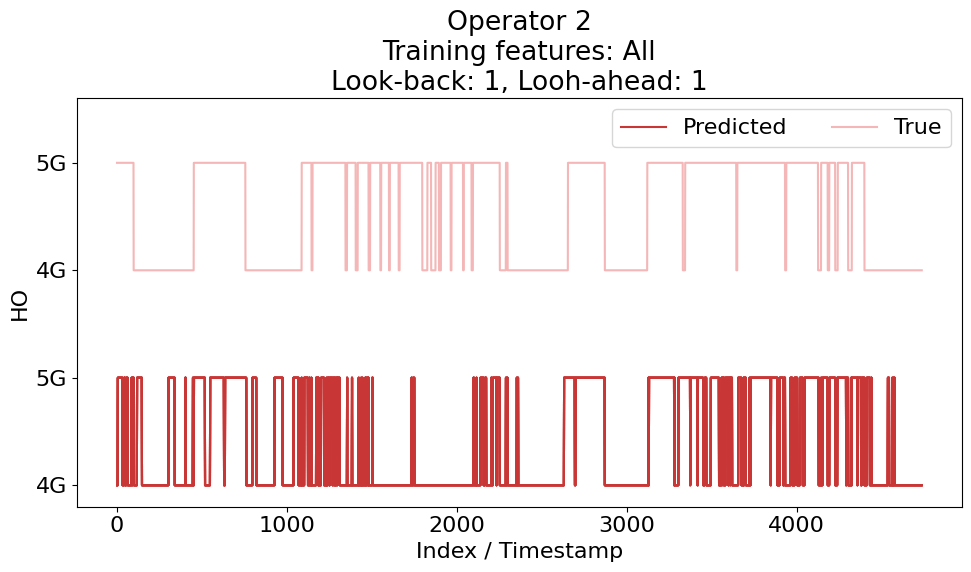

In [51]:
combination = 'All'
comb = x1n1[combination]
pred = comb['y_pred_plot']
true = comb['y_true_plot']
train_pred = comb['train_pred_plot']
train_true = comb['train_true_plot']

fig = plot_mode(pred=pred, true=true, operator=operator, test_train='test', comb=combination, n_steps_in=1, n_steps_out=1)
fig.savefig(r'../latex/plots/lstm_mode/op2_1_look-back_1_look-ahead.pdf')

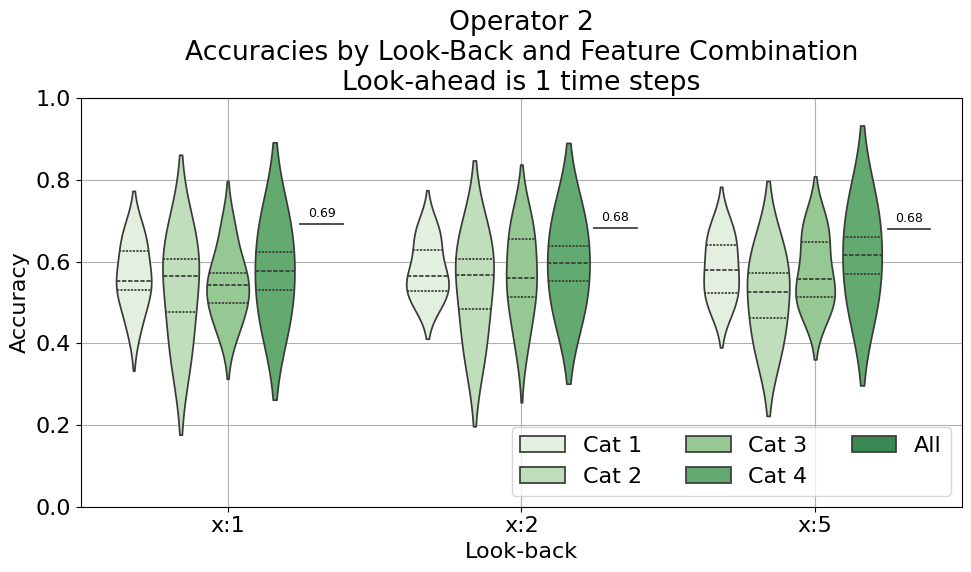

In [18]:
fig = box_lookback(step1_results, n_steps_out=1, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n1.pdf')

In [19]:
n_steps_ins, n_steps_out = [1, 2, 5], 2

step2_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step2_results[f'x:{n_steps_in}'] = temp_results

In [20]:
x1n2 = step2_results['x:1']

x1n2_results = pd.DataFrame.from_dict(x1n2, orient='index')
x1n2_results.reset_index(inplace=True)
x1n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n2_results = x1n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.406,1.000,0.012,0.516,1.000,0.017
1,SINR,0.511,0.590,0.615,0.611,0.570,0.847
2,RSRQ,0.535,0.584,0.784,0.501,0.496,0.880
3,"RSRP, SINR",0.529,0.607,0.612,0.616,0.576,0.833
4,"RSRP, RSRQ",0.417,0.983,0.031,0.520,0.797,0.032
5,"SINR, RSRQ",0.464,0.571,0.436,0.633,0.603,0.741
6,"RSRP, SINR, RSRQ",0.534,0.606,0.642,0.663,0.606,0.901
7,SSS_RSRP,0.670,0.877,0.525,0.754,0.886,0.573
8,SSS_SINR,0.644,0.812,0.530,0.792,0.831,0.724
9,SSS_RSRQ,0.567,0.818,0.359,0.731,0.891,0.515


In [21]:
x2n2 = step2_results['x:2']

x2n2_results = pd.DataFrame.from_dict(x2n2, orient='index')
x2n2_results.reset_index(inplace=True)
x2n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n2_results = x2n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.504,0.747,0.264,0.596,0.757,0.264
1,SINR,0.510,0.605,0.528,0.653,0.607,0.837
2,RSRQ,0.542,0.588,0.795,0.501,0.496,0.880
3,"RSRP, SINR",0.419,0.527,0.317,0.630,0.624,0.621
4,"RSRP, RSRQ",0.541,0.651,0.509,0.386,0.392,0.451
5,"SINR, RSRQ",0.509,0.584,0.637,0.618,0.569,0.921
6,"RSRP, SINR, RSRQ",0.508,0.602,0.532,0.651,0.613,0.789
7,SSS_RSRP,0.399,0.000,0.000,0.508,0.000,0.000
8,SSS_SINR,0.642,0.813,0.524,0.799,0.843,0.725
9,SSS_RSRQ,0.565,0.795,0.372,0.743,0.878,0.555


In [22]:
x5n2 = step2_results['x:5']

x5n2_results = pd.DataFrame.from_dict(x5n2, orient='index')
x5n2_results.reset_index(inplace=True)
x5n2_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n2_results = x5n2_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n2_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.489,0.642,0.336,0.615,0.762,0.317
1,SINR,0.513,0.598,0.577,0.627,0.585,0.837
2,RSRQ,0.567,0.595,0.877,0.520,0.507,0.962
3,"RSRP, SINR",0.556,0.604,0.753,0.620,0.571,0.919
4,"RSRP, RSRQ",0.600,0.600,1.000,0.492,0.492,1.000
5,"SINR, RSRQ",0.550,0.625,0.624,0.667,0.616,0.856
6,"RSRP, SINR, RSRQ",0.533,0.621,0.569,0.604,0.581,0.703
7,SSS_RSRP,0.400,0.000,0.000,0.508,0.000,0.000
8,SSS_SINR,0.652,0.798,0.564,0.794,0.800,0.775
9,SSS_RSRQ,0.584,0.792,0.416,0.739,0.816,0.607


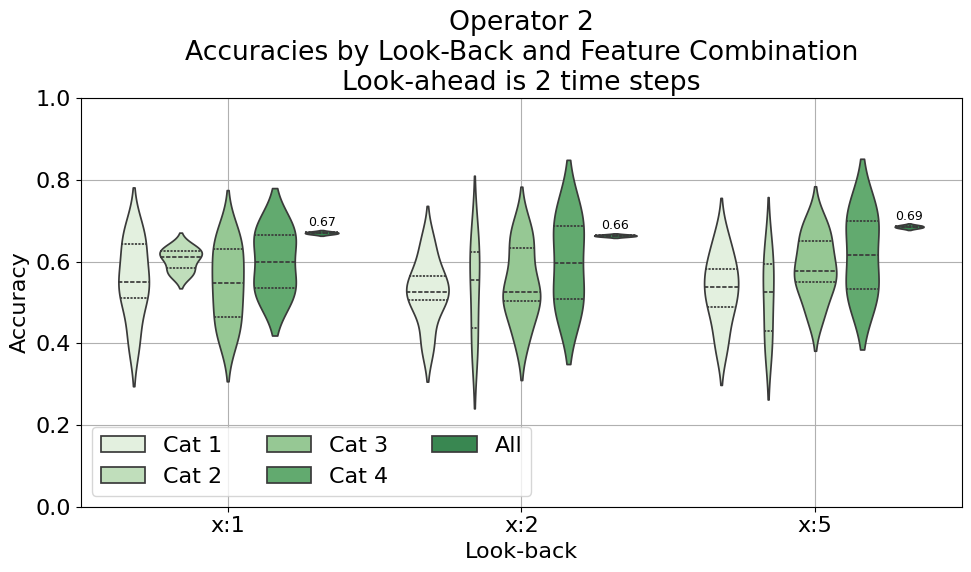

In [23]:
fig = box_lookback(step2_results, n_steps_out=2, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n2.pdf')

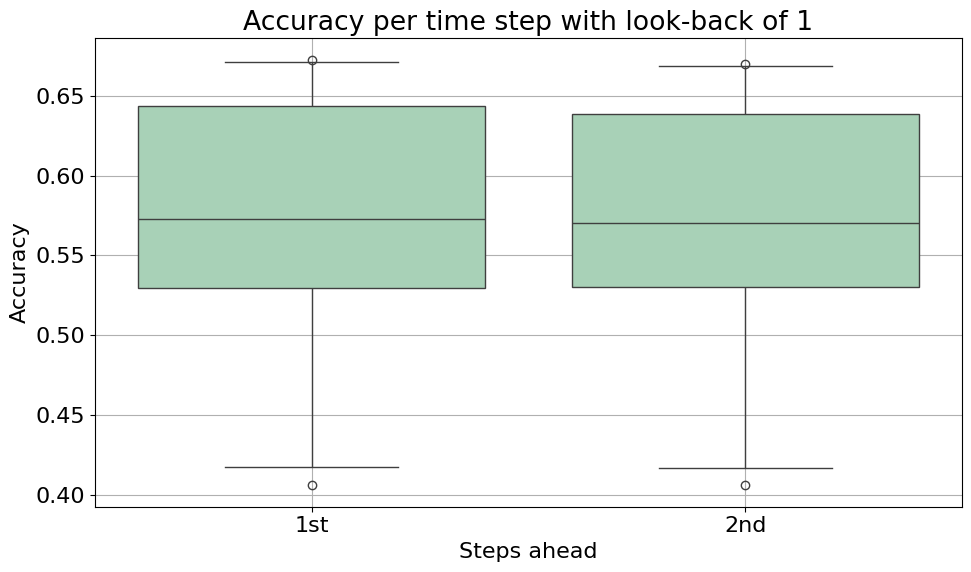

In [52]:
fig = boxplot_accuracies(step2_results['x:1'], n_steps_out=2, n_steps_in=1)
fig.savefig(r'../latex/plots/lstm_mode/op2_box_x1n2.pdf')

In [24]:
n_steps_ins, n_steps_out = [1, 3, 5], 3

step3_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step3_results[f'x:{n_steps_in}'] = temp_results

In [25]:
x1n3 = step3_results['x:1']

x1n3_results = pd.DataFrame.from_dict(x1n3, orient='index')
x1n3_results.reset_index(inplace=True)
x1n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x1n3_results = x1n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x1n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.399,0.000,0.000,0.508,0.000,0.000
1,SINR,0.512,0.607,0.533,0.639,0.598,0.811
2,RSRQ,0.532,0.587,0.743,0.516,0.505,0.856
3,"RSRP, SINR",0.437,0.546,0.369,0.636,0.611,0.717
4,"RSRP, RSRQ",0.548,0.599,0.751,0.548,0.527,0.797
5,"SINR, RSRQ",0.528,0.617,0.566,0.660,0.614,0.831
6,"RSRP, SINR, RSRQ",0.482,0.640,0.315,0.612,0.726,0.339
7,SSS_RSRP,0.639,0.667,0.799,0.622,0.571,0.938
8,SSS_SINR,0.642,0.809,0.528,0.790,0.829,0.722
9,SSS_RSRQ,0.572,0.908,0.321,0.713,0.921,0.456


In [26]:
x3n3 = step3_results['x:3']

x3n3_results = pd.DataFrame.from_dict(x3n3, orient='index')
x3n3_results.reset_index(inplace=True)
x3n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x3n3_results = x3n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x3n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.498,0.636,0.383,0.606,0.676,0.382
1,SINR,0.518,0.603,0.576,0.627,0.584,0.838
2,RSRQ,0.564,0.588,0.913,0.513,0.503,0.972
3,"RSRP, SINR",0.601,0.601,1.000,0.492,0.492,1.000
4,"RSRP, RSRQ",0.481,0.597,0.416,0.616,0.670,0.431
5,"SINR, RSRQ",0.495,0.579,0.584,0.668,0.618,0.858
6,"RSRP, SINR, RSRQ",0.568,0.630,0.678,0.651,0.596,0.908
7,SSS_RSRP,0.399,0.000,0.000,0.508,0.000,0.000
8,SSS_SINR,0.650,0.812,0.542,0.788,0.815,0.735
9,SSS_RSRQ,0.607,0.765,0.498,0.724,0.730,0.698


In [27]:
x5n3 = step3_results['x:5']

x5n3_results = pd.DataFrame.from_dict(x5n3, orient='index')
x5n3_results.reset_index(inplace=True)
x5n3_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n3_results = x5n3_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n3_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.509,0.579,0.666,0.567,0.547,0.710
1,SINR,0.482,0.610,0.383,0.650,0.634,0.684
2,RSRQ,0.563,0.592,0.875,0.526,0.510,0.960
3,"RSRP, SINR",0.424,0.533,0.326,0.639,0.629,0.651
4,"RSRP, RSRQ",0.499,0.580,0.598,0.598,0.588,0.618
5,"SINR, RSRQ",0.489,0.577,0.560,0.679,0.619,0.906
6,"RSRP, SINR, RSRQ",0.533,0.609,0.624,0.652,0.605,0.842
7,SSS_RSRP,0.419,1.000,0.033,0.518,0.969,0.023
8,SSS_SINR,0.643,0.797,0.544,0.808,0.831,0.767
9,SSS_RSRQ,0.583,0.896,0.346,0.725,0.917,0.485


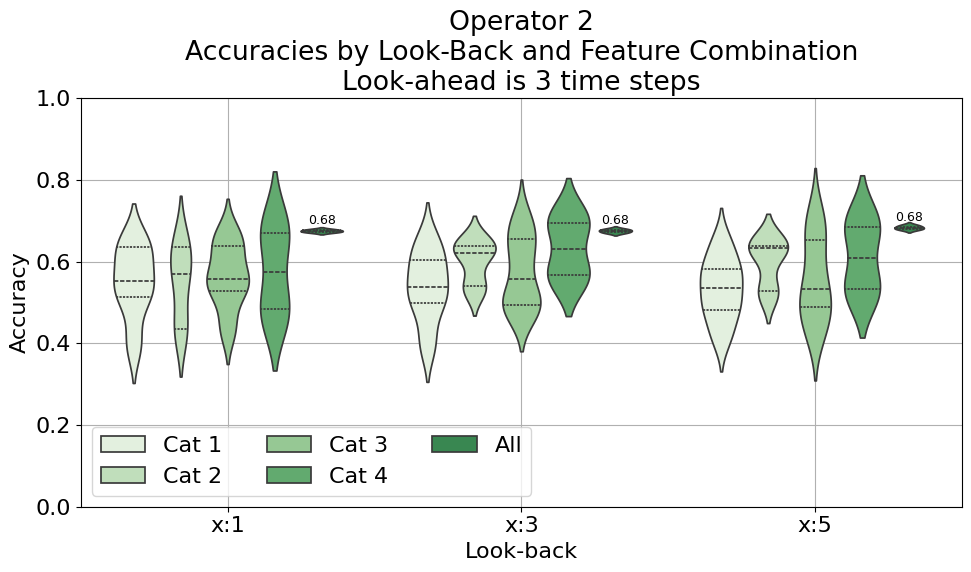

In [28]:
fig = box_lookback(step3_results, n_steps_out=3, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n3.pdf')

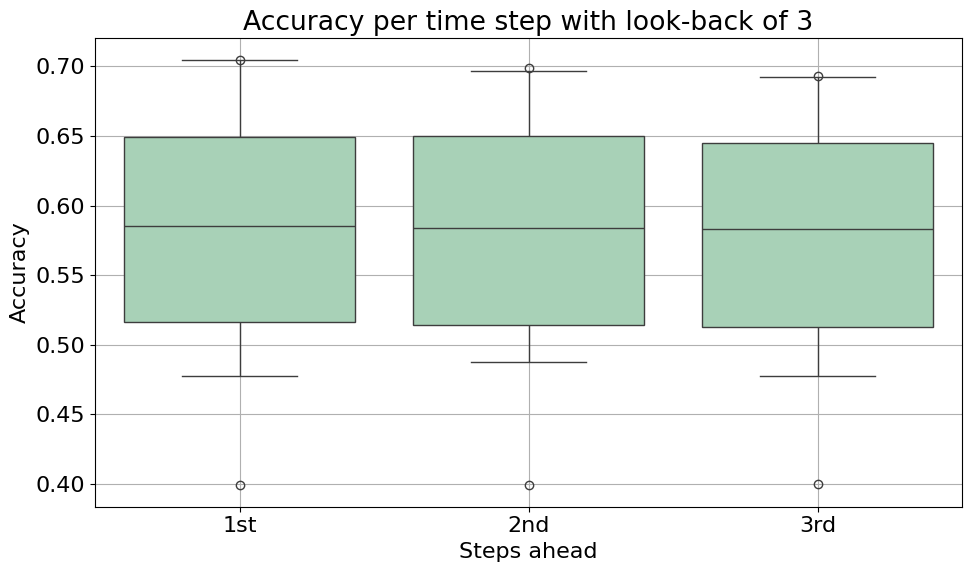

In [53]:
fig = boxplot_accuracies(x3n3, n_steps_out=3, n_steps_in=3)
fig.savefig(r'../latex/plots/lstm_mode/op2_box_x3n3.pdf')

In [29]:
n_steps_ins, n_steps_out = [2, 5, 8], 5

step5_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step5_results[f'x:{n_steps_in}'] = temp_results

In [30]:
x2n5 = step5_results['x:2']

x2n5_results = pd.DataFrame.from_dict(x2n5, orient='index')
x2n5_results.reset_index(inplace=True)
x2n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n5_results = x2n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.487,0.968,0.151,0.531,0.815,0.063
1,SINR,0.505,0.599,0.531,0.625,0.586,0.812
2,RSRQ,0.492,0.586,0.525,0.570,0.553,0.660
3,"RSRP, SINR",0.578,0.640,0.680,0.615,0.572,0.866
4,"RSRP, RSRQ",0.422,0.966,0.039,0.526,0.858,0.044
5,"SINR, RSRQ",0.537,0.615,0.613,0.638,0.590,0.867
6,"RSRP, SINR, RSRQ",0.531,0.599,0.664,0.639,0.591,0.865
7,SSS_RSRP,0.656,0.731,0.675,0.666,0.624,0.811
8,SSS_SINR,0.639,0.806,0.525,0.792,0.831,0.724
9,SSS_RSRQ,0.577,0.761,0.431,0.733,0.783,0.632


In [31]:
x5n5 = step5_results['x:5']

x5n5_results = pd.DataFrame.from_dict(x5n5, orient='index')
x5n5_results.reset_index(inplace=True)
x5n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n5_results = x5n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.498,0.758,0.242,0.549,0.643,0.190
1,SINR,0.506,0.611,0.488,0.655,0.618,0.784
2,RSRQ,0.534,0.603,0.654,0.526,0.513,0.750
3,"RSRP, SINR",0.530,0.617,0.574,0.629,0.591,0.806
4,"RSRP, RSRQ",0.532,0.606,0.632,0.555,0.540,0.661
5,"SINR, RSRQ",0.503,0.588,0.576,0.671,0.616,0.884
6,"RSRP, SINR, RSRQ",0.500,0.592,0.537,0.673,0.630,0.814
7,SSS_RSRP,0.400,0.000,0.000,0.507,0.000,0.000
8,SSS_SINR,0.634,0.802,0.519,0.801,0.841,0.735
9,SSS_RSRQ,0.573,0.788,0.395,0.744,0.852,0.583


In [32]:
x8n5 = step5_results['x:8']

x8n5_results = pd.DataFrame.from_dict(x8n5, orient='index')
x8n5_results.reset_index(inplace=True)
x8n5_results.rename(columns={'index': 'Combination'}, inplace=True)
x8n5_results = x8n5_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x8n5_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.509,0.582,0.644,0.582,0.559,0.726
1,SINR,0.504,0.615,0.465,0.665,0.635,0.756
2,RSRQ,0.593,0.598,0.983,0.507,0.500,0.973
3,"RSRP, SINR",0.503,0.596,0.534,0.625,0.594,0.761
4,"RSRP, RSRQ",0.486,0.612,0.391,0.610,0.724,0.341
5,"SINR, RSRQ",0.466,0.570,0.448,0.676,0.633,0.819
6,"RSRP, SINR, RSRQ",0.489,0.595,0.466,0.676,0.644,0.769
7,SSS_RSRP,0.600,0.600,1.000,0.494,0.494,1.000
8,SSS_SINR,0.625,0.773,0.530,0.824,0.845,0.789
9,SSS_RSRQ,0.602,0.756,0.496,0.731,0.745,0.691


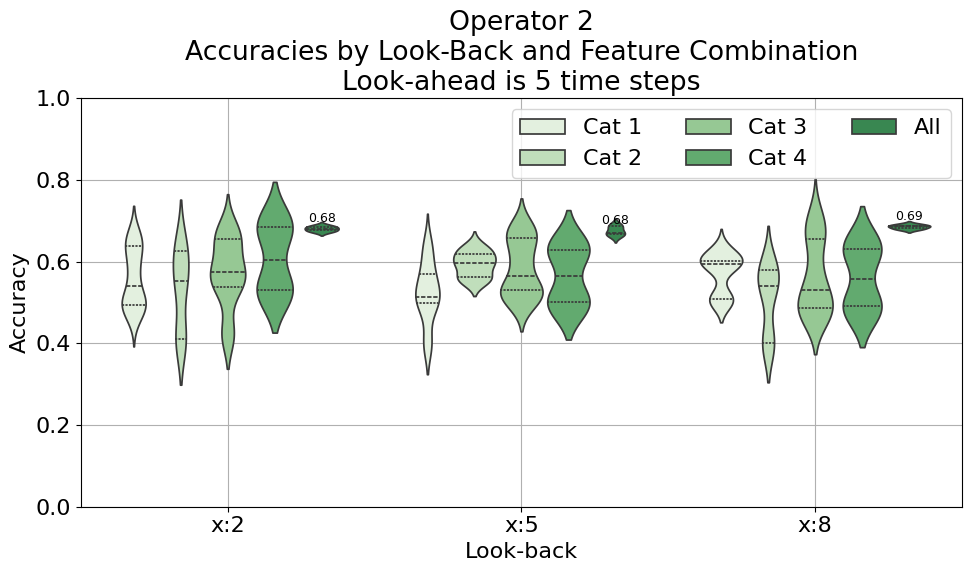

In [33]:
fig = box_lookback(step5_results, n_steps_out=5, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n5.pdf')

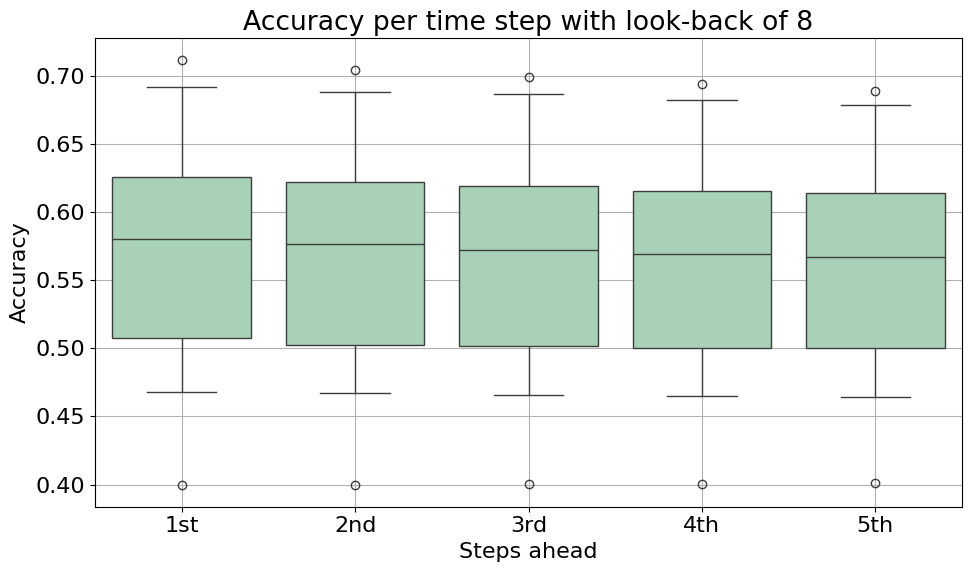

In [54]:
fig = boxplot_accuracies(x8n5, n_steps_out=5, n_steps_in=8)
fig.savefig(r'../latex/plots/lstm_mode/op2_box_x8n5.pdf')

In [34]:
n_steps_ins, n_steps_out = [2, 5, 10, 15], 10

step10_results = {}

for n_steps_in in n_steps_ins:
    temp_results = {}
    for target in target_features:
        for features in feature_selection:
            used_features = f''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            features.append('campaign')
            features.append('Mode')
            warnings.simplefilter(action='ignore')
            temp_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)
    step10_results[f'x:{n_steps_in}'] = temp_results

In [35]:
x2n10 = step10_results['x:2']

x2n10_results = pd.DataFrame.from_dict(x2n10, orient='index')
x2n10_results.reset_index(inplace=True)
x2n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x2n10_results = x2n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x2n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.451,0.975,0.088,0.526,0.877,0.045
1,SINR,0.512,0.609,0.528,0.645,0.604,0.816
2,RSRQ,0.566,0.591,0.899,0.523,0.509,0.972
3,"RSRP, SINR",0.535,0.614,0.611,0.630,0.591,0.812
4,"RSRP, RSRQ",0.482,0.967,0.143,0.526,0.877,0.045
5,"SINR, RSRQ",0.504,0.593,0.559,0.669,0.618,0.861
6,"RSRP, SINR, RSRQ",0.508,0.602,0.538,0.660,0.618,0.814
7,SSS_RSRP,0.432,0.939,0.058,0.530,0.961,0.050
8,SSS_SINR,0.637,0.796,0.533,0.772,0.798,0.719
9,SSS_RSRQ,0.561,0.748,0.407,0.728,0.788,0.615


In [36]:
x5n10 = step10_results['x:5']

x5n10_results = pd.DataFrame.from_dict(x5n10, orient='index')
x5n10_results.reset_index(inplace=True)
x5n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x5n10_results = x5n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x5n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.601,0.601,1.000,0.494,0.494,1.000
1,SINR,0.508,0.604,0.528,0.672,0.628,0.821
2,RSRQ,0.584,0.595,0.959,0.514,0.504,0.986
3,"RSRP, SINR",0.527,0.611,0.584,0.552,0.536,0.681
4,"RSRP, RSRQ",0.528,0.604,0.622,0.590,0.588,0.566
5,"SINR, RSRQ",0.481,0.584,0.472,0.699,0.653,0.834
6,"RSRP, SINR, RSRQ",0.469,0.589,0.384,0.637,0.625,0.659
7,SSS_RSRP,0.466,0.925,0.120,0.559,0.939,0.115
8,SSS_SINR,0.648,0.796,0.557,0.781,0.793,0.753
9,SSS_RSRQ,0.555,0.773,0.366,0.732,0.860,0.545


In [37]:
x10n10 = step10_results['x:10']

x10n10_results = pd.DataFrame.from_dict(x10n10, orient='index')
x10n10_results.reset_index(inplace=True)
x10n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x10n10_results = x10n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x10n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.498,0.600,0.489,0.594,0.607,0.509
1,SINR,0.497,0.581,0.579,0.642,0.599,0.834
2,RSRQ,0.600,0.600,1.000,0.495,0.495,1.000
3,"RSRP, SINR",0.517,0.599,0.591,0.635,0.602,0.779
4,"RSRP, RSRQ",0.598,0.600,0.989,0.498,0.496,0.992
5,"SINR, RSRQ",0.484,0.575,0.532,0.685,0.634,0.859
6,"RSRP, SINR, RSRQ",0.525,0.590,0.685,0.630,0.585,0.873
7,SSS_RSRP,0.653,0.839,0.521,0.732,0.832,0.575
8,SSS_SINR,0.607,0.739,0.533,0.820,0.847,0.776
9,SSS_RSRQ,0.581,0.737,0.468,0.735,0.770,0.663


In [38]:
x15n10 = step10_results['x:15']

x15n10_results = pd.DataFrame.from_dict(x15n10, orient='index')
x15n10_results.reset_index(inplace=True)
x15n10_results.rename(columns={'index': 'Combination'}, inplace=True)
x15n10_results = x15n10_results.drop(['y_pred', 'y_true', 'train_true', 'train_pred', 'y_pred_plot', 'y_true_plot', 'train_pred_plot', 'train_true_plot', 'Accuracy_list', 'Accuracy_train_list'], axis=1)
x15n10_results

,Combination,Accuracy,Precision,Recall,Accuracy_train,Precision_train,Recall_train
0,RSRP,0.599,0.599,1.000,0.496,0.496,1.000
1,SINR,0.493,0.600,0.457,0.663,0.634,0.758
2,RSRQ,0.599,0.599,1.000,0.496,0.496,1.000
3,"RSRP, SINR",0.472,0.577,0.444,0.654,0.624,0.757
4,"RSRP, RSRQ",0.571,0.616,0.755,0.552,0.536,0.714
5,"SINR, RSRQ",0.476,0.572,0.493,0.698,0.656,0.820
6,"RSRP, SINR, RSRQ",0.475,0.567,0.519,0.638,0.600,0.805
7,SSS_RSRP,0.657,0.773,0.603,0.724,0.722,0.719
8,SSS_SINR,0.633,0.774,0.547,0.851,0.879,0.810
9,SSS_RSRQ,0.577,0.774,0.415,0.739,0.848,0.577


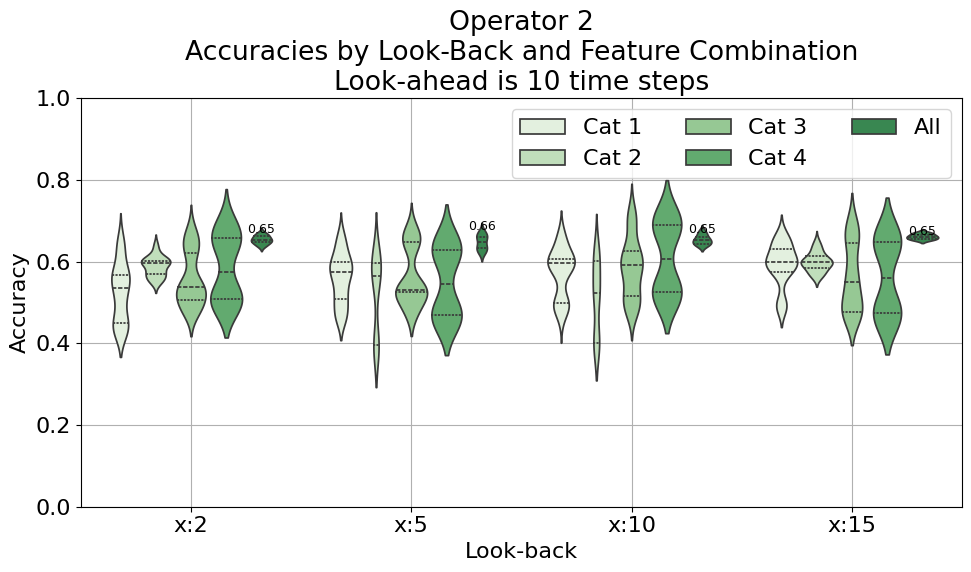

In [39]:
fig = box_lookback(step10_results, n_steps_out=10, operator=operator)
fig.savefig(r'../latex/plots/lstm_mode/op2_violin_n10.pdf')

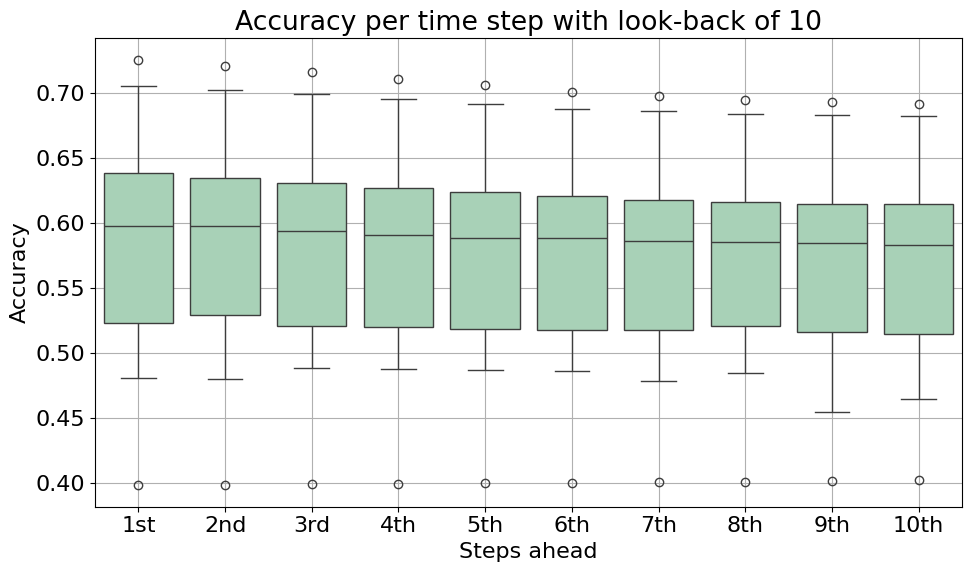

In [55]:
fig = boxplot_accuracies(x10n10, n_steps_out=10, n_steps_in=10)
fig.savefig(r'../latex/plots/lstm_mode/op2_box_x10n10.pdf')